In [61]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sygma as s
reload(s)
import omega as o
reload(o)
import chem_evol as c
reload(c)

<module 'chem_evol' from 'chem_evol.pyc'>

## Initialisation

In [62]:
# Do a SYGMA run for each NuGrid metallicity

s_02 = s.sygma(iniZ=0.02, imf_type='salpeter')
s_01 = s.sygma(iniZ=0.01, imf_type='salpeter')
s_006 = s.sygma(iniZ=0.006, imf_type='salpeter')
s_001 = s.sygma(iniZ=0.001, imf_type='salpeter')
s_0001 = s.sygma(iniZ=0.0001, imf_type='salpeter')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.56s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.68s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.61s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.62s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.63s


In [63]:
# Show the number of neutron star mergers at each timestep; should not be negative, and should be roughly equal!

print np.sum(s_02.history.nsm_numbers)
print np.sum(s_01.history.nsm_numbers)
print np.sum(s_006.history.nsm_numbers)
print np.sum(s_001.history.nsm_numbers)
print np.sum(s_0001.history.nsm_numbers)

0.109535502807
0.108478909105
0.108056271737
0.107633634269
0.107633634271


## IMF check

The Salpeter allows one to calculate the number of stars $N_{12}$ in the mass interval [m1, m2] with

(I) $N_{12} = k_N \int _{m1}^{m2} m^{-2.35} dm$ 

Where $k_{N}$ is the normalization constant, which can be derived from the total amount of mass in the system $M_{tot}$.
Since the total mass $M_{12}$ in the mass interval above can be estimated with

(II) $M_{12} = k_N \int _{m1}^{m2} m^{-1.35} dm$

the mass interval of [8, 100] for neutron star progenitors, [0.1, 100] for the total mass, and $M_{tot}=1e4$ will yield for $k_N$:

$1e4 = \frac{k_N}{0.35}(0.1^{-0.35} - 100^{-0.35})$

In [67]:
# Name the relevant quantities
mtot = s_001.mgal
nsm_l = s_001.transitionmass
imf0 = s_001.imf_bdys[0]
imf1 = s_001.imf_bdys[1]

# Compute the normalization constant as defined above
k_N = (mtot*0.35) / (imf0**-0.35 - imf1**-0.35) #(I)

The total number of NS merger progenitors $N_{12}$ is then:

$N_{12} = \frac{k_N}{1.35}(8^{-1.35} - 100^{-1.35})$

In [68]:
# Compute the total number of neutron star merger progenitors as defined above
N_nsm = (k_N/1.35) * (nsm_l**-1.35 - imf1**-1.35)

Compared to a SYGMA run:

In [69]:
# Compute the number of NS merger progenitors in one of the SYGMA runs (normalize to mgal)
A_imf = mtot / s_001._imf(imf0, imf1, 2)
N_sim = A_imf * s_001._imf(nsm_l, imf1, 1)

print 'Theoretical number of neutron star progenitors: ', N_nsm
print 'Number of neutron star progenitors in SYGMA run: ', N_sim
print 'Ratio (should be ~1): ', N_sim / N_nsm

Theoretical number of neutron star progenitors:  74.2177993298
Number of neutron star progenitors in SYGMA run:  74.2177993298
Ratio (should be ~1):  1.0


## Ensure r-process yields are being read in properly

In [43]:
# Obtain the fractional isotope yields from a SYGMA run
l = len(s_01.history.ism_iso_yield_nsm)
y = s_01.history.ism_iso_yield_nsm[l-1]
n = np.sum(y)
yields = y / n

# Exclude isotopes for which there are no r-process yields in the yield table
nonzero = np.nonzero(yields)
yields = yields[nonzero]

In [44]:
# Obtain the mass numbers for the isotopes (x-axis ticks)
massnums = []

for i in s_01.history.isotopes:
    massnum = i.split('-')[1]
    massnums.append(float(massnum))

# Again exclude zero values
massnums = np.asarray(massnums)
massnums = massnums[nonzero]

In [45]:
# Hacky text parser to get all the fractional isotope values from the r-process yield table
r_yields_text = open('yield_tables/r_process_rosswog_2014.txt')
r_yields = r_yields_text.readlines()
lines = []

for line in r_yields:
    lines.append(line)

newlines = []

for line in lines:
    if '&' in line:
        new = line.strip()
        new = new.split('&')
        newlines.append(new)
        
massfracs = []
rmassnums = []
        
for ind, el in enumerate(newlines):
    if ind is not 0:
        massfracs.append(float(el[2]))
        rmassnums.append(float(el[1].split('-')[1]))

# Array of r-process yields to compare with simulation yields
massfracs = np.asarray(massfracs)

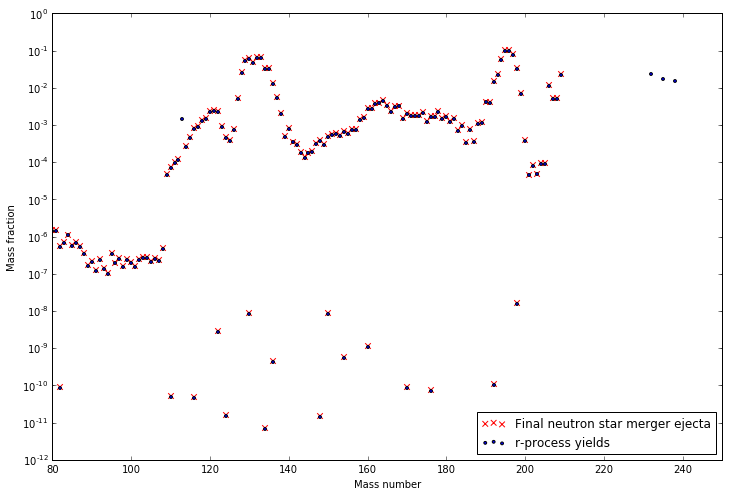

In [46]:
# Plot r-process yields against neutron star merger simulation yields (should be nearly identical)

plt.figure(figsize=(12,8))
plt.scatter(massnums, yields, marker='x', s=32, color='red', label='Final neutron star merger ejecta')
plt.scatter(rmassnums, massfracs, s=8, label='r-process yields')
plt.xlim(80, 250)
plt.ylim(0.000000000001, 1)
plt.yscale('log')
plt.xlabel('Mass number')
plt.ylabel('Mass fraction')
plt.legend(loc=4)
#plt.savefig('yield_comparison.png', dpi=200)

## Check DTD fits

In [1]:
# Define the three functions which are fit to the DTD (Power law, 5th and 6th degree polynomials)

def quintic(t, a, b, c, d, e, f): 
    y = (a*(t**5))+(b*(t**4))+(c*(t**3))+(d*(t**2))+(e*t)+f
    return y

def sextic(t, a, b, c, d, e, f, g):
    y = a*(t**6) + b*(t**5) + c*(t**4) + d*(t**3) + e*(t**2) + f*t + g
    return y

def powlaw(a, t):
    y = a / t
    return y

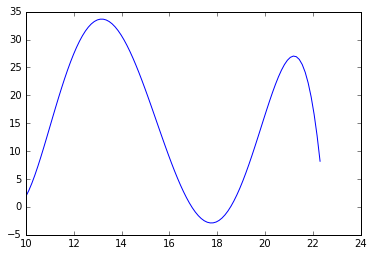

In [60]:
# Solar metallicity fit, parameters from chem_evol (see fitting notebook to derive new parameters)
a = -0.0138858377011
b = 1.0712569392
c = -32.1555682584
d = 468.236521089
e = -3300.97955814
f = 9019.62468302
t = np.linspace(10, 22.2987, 100) # Polynomial portion of solar metallicity DTD x-axis

# Define the DTD fit and plot it
y = quintic(t, a, b, c, d, e, f)
plt.plot(t, y)

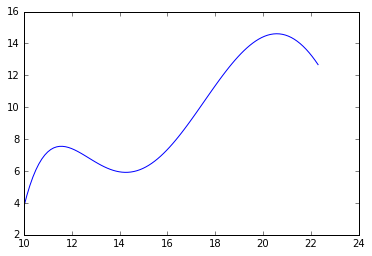

In [15]:
a = -2.88192413434e-5
b = 0.00387383125623
c = -0.20721471544
d = 5.64382310405
e = -82.6061154979
f = 617.464778362
g = -1840.49386605

y = sextic(t, a, b, c, d, e, f, g)
plt.plot(t, y)